# Sensitivity analysis of emergent constraint

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import xarray as xr
import dask

import datasets
import emergent_constraint as ec
import figure_panels
import obs_aircraft
import obs_surface
import models
import util

In [3]:
use_dask = True

if use_dask:
    from ncar_jobqueue import NCARCluster
    from dask.distributed import Client
    
    cluster = NCARCluster()
    cluster.scale(4)
    client = Client(cluster) # Connect this local process to remote workers
else:
    cluster = None
    client = None
cluster

/glade/work/mclong/miniconda3/envs/so-co2/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44287 instead
  f"Port {expected} is already in use.\n"


## Compute constraint varying region boundary

In [4]:
max_lat = -30.
min_lat = -70.
flux_lat_ranges = [(-90., x) for x in np.arange(min_lat, max_lat+1, 1)]

In [5]:
flux_memory_dist = [30, 90]
ubin_dist = np.arange(290., 315, 1.)
gradient_lat_ranges = [(-90., x) for x in np.arange(-45., -30.+1., 5.)]

def df_constructor():
    cols = ['flux_lat_range', 'gradient_lat_range', 'flux_memory', 'ubin',]
    index = list(set(
        [ndx for ndx in product(flux_lat_ranges, gradient_lat_ranges, flux_memory_dist, [300.],)] +
        [ndx for ndx in product([(-90., -45.)], [(-90., -45.)], [90], ubin_dist,)]
    ))
    df = pd.DataFrame(index, columns=cols).set_index(cols)
    return df
df_constructor()

Empty DataFrame
Columns: []
Index: [((-90.0, -35.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -36.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -45.0), (-90.0, -45.0), 90, 304.0), ((-90.0, -69.0), (-90.0, -40.0), 90, 300.0), ((-90.0, -38.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -65.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -55.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -36.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -45.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -41.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -43.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -40.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -30.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -52.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -37.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -43.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -56.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -43.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -39.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -66.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -32.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -45.0), (-90.0, -40.0), 90, 300.0), ((-90.0, -63.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -35.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -46.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -58.0), (-90.0, -40.0), 90, 300.0), ((-90.0, -36.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -61.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -38.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -30.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -41.0), (-90.0, -40.0), 90, 300.0), ((-90.0, -63.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -56.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -30.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -58.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -51.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -50.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -70.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -69.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -45.0), (-90.0, -45.0), 90, 297.0), ((-90.0, -51.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -51.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -48.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -45.0), (-90.0, -45.0), 90, 291.0), ((-90.0, -30.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -45.0), (-90.0, -45.0), 90, 293.0), ((-90.0, -51.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -51.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -32.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -48.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -60.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -45.0), (-90.0, -45.0), 90, 305.0), ((-90.0, -33.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -63.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -63.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -67.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -67.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -44.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -70.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -60.0), (-90.0, -40.0), 90, 300.0), ((-90.0, -54.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -41.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -44.0), (-90.0, -40.0), 90, 300.0), ((-90.0, -31.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -38.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -44.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -52.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -39.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -41.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -66.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -47.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -37.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -54.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -51.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -52.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -47.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -65.0), (-90.0, -45.0), 90, 300.0), ((-90.0, -46.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -31.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -58.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -31.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -33.0), (-90.0, -35.0), 90, 300.0), ((-90.0, -52.0), (-90.0, -30.0), 30, 300.0), ((-90.0, -54.0), (-90.0, -40.0), 30, 300.0), ((-90.0, -44.0), (-90.0, -30.0), 90, 300.0), ((-90.0, -53.0), (-90.0, -45.0), 30, 300.0), ((-90.0, -40.0), (-90.0, -35.0), 30, 300.0), ((-90.0, -34.0), (-90.0, -45.0), 30, 300.0), ((-9

In [6]:
def signal2noise_flux(sc_or_ac, key):
    """compute signal to noise metric from ratio of estimated flux and associated error"""
    if isinstance(sc_or_ac,  ec.surface_constraint):
        df = sc_or_ac.surface_flux
        signal = df.loc[('2009-2020', key)].flux
        noise = df.loc[('2009-2020', key)].flux_error
        return np.abs(signal) / noise
    
    elif isinstance(sc_or_ac,  ec.aircraft_constraint):    
        df = sc_or_ac.campaign_flux
        signal = df.loc[sc_or_ac.campaign_groups[key]].flux.mean()
        noise = np.sqrt(
        np.sum(df.loc[sc_or_ac.campaign_groups[key]].flux_error**2)
            ) / len(sc_or_ac.campaign_groups[key])
        return np.abs(signal) / noise

def signal2noise(sc_or_ac, key):
    """compute signal to noise metric from constraint properties"""    
    N = int(1e6)
    if isinstance(sc_or_ac,  ec.surface_constraint):
        ndx = ('2009-2020', key)
    else:
        ndx = key
        
    beta = np.random.multivariate_normal(
        mean=sc_or_ac.df_fits.loc[ndx].fit_beta,
        cov=sc_or_ac.df_fits.loc[ndx].fit_cov_beta,
        size=N,
    )
    signal = sc_or_ac.df_fits.loc[ndx].fit_beta[0]
    noise = beta.std(axis=0)[0]
    return np.abs(signal) / noise
    

In [7]:
%%time
clobber = False
clobber_deep = False
air_parms = ec.get_parameters('default')

obj_srf = {}; obj_air = {};
acs_lat = {}; 
acs_ubin = {}; 
scs = {};
dfs = {}
for constraint_type in ['ocean_constraint',]:
    model_input_lists = ec.get_model_tracer_lists(constraint_type)
    obj_srf[constraint_type] = ec.whole_enchilada_srf(**model_input_lists)       
    scs[constraint_type] = obj_srf[constraint_type].sensitivity(
        'flux_lat_range', flux_lat_ranges, clobber=clobber, use_dask=use_dask,
    )
    
for constraint_type in ['ocean_constraint',]:    
    model_input_lists = ec.get_model_tracer_lists(constraint_type)
    obj_air[constraint_type] = ec.whole_enchilada(clobber=clobber_deep, **model_input_lists)
    
    df = df_constructor()
    
    results = []; acs = []
    for ndx in df.index:
        parameters = dict(**ec.get_parameters())
        for n, name in enumerate(df.index.names):
            parameters[name] = ndx[n]
        results.append(
            dask.delayed(obj_air[constraint_type].get_ac)(
                **parameters,
                clobber=clobber,
            )
        )
        if len(results) == 12:
            with util.timer(name=f'compute {len(results)}', normalize=len(results)):
                acs.extend(dask.compute(*results)) 
            print(f'completed {len(acs)}')                
            results = []
    
    if results:
        acs.extend(dask.compute(*results)) 
    
    for key in acs[0].fit_groups:
        df[f's2n_{key}'] = [ac.df_fits.loc[key].fit_s2n for ac in acs]
    df['flux'] = [ac.estimate_ann_mean_flux[0] for ac in acs]
    df['flux_err'] = [ac.estimate_ann_mean_flux[1] for ac in acs]    
    df['object'] = [ac for ac in acs]
    
    dfs[constraint_type] = df

[compute 12]: 1.76322s/process
completed 12
[compute 12]: 1.72459s/process
completed 24
[compute 12]: 1.92227s/process
completed 36
[compute 12]: 1.68095s/process
completed 48
[compute 12]: 1.70834s/process
completed 60
[compute 12]: 1.69190s/process
completed 72
[compute 12]: 1.66130s/process
completed 84
[compute 12]: 1.66906s/process
completed 96
[compute 12]: 2.01316s/process
completed 108
[compute 12]: 11.52124s/process
completed 120
[compute 12]: 8.79121s/process
completed 132
[compute 12]: 11.58234s/process
completed 144
[compute 12]: 11.82575s/process
completed 156
[compute 12]: 8.89237s/process
completed 168
[compute 12]: 9.43475s/process
completed 180
[compute 12]: 9.12501s/process
completed 192
[compute 12]: 11.63088s/process
completed 204
[compute 12]: 10.27821s/process
completed 216
[compute 12]: 8.75280s/process
completed 228
[compute 12]: 9.18862s/process
completed 240
[compute 12]: 8.98432s/process
completed 252
[compute 12]: 9.93136s/process
completed 264
[compute 12]:

In [8]:
if cluster is not None:
    cluster.close()
    client.close()

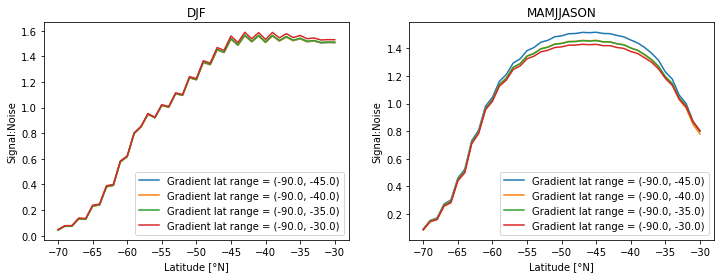

In [9]:
ubin = 300.
flux_memory = 90
constraint_type = 'ocean_constraint'
df = dfs[constraint_type]

fig, axs = util.canvas(1, 2)

for n, group in enumerate(['DJF', 'MAMJJASON']):
    ax = axs[0, n]
    s2n = np.empty((len(flux_lat_ranges), len(gradient_lat_ranges)))
    for i, flux_lat_range in enumerate(flux_lat_ranges):
        for j, gradient_lat_range in enumerate(gradient_lat_ranges):
            s2n[i, j] = df.loc[(flux_lat_range, gradient_lat_range, flux_memory, ubin)][f's2n_{group}']

    for j in range(len(gradient_lat_ranges)):
        ax.plot([l[-1] for l in flux_lat_ranges], s2n[:, j], 
                 label=f'Gradient lat range = {gradient_lat_ranges[j]}')

    ax.set_xlabel('Latitude [°N]')
    ax.set_ylabel('Signal:Noise')
    ax.legend();
    ax.set_title(group)

## Sensitivity to θ-bin parameters

In [10]:
df_obs = obs_aircraft.open_aircraft_data('obs')    
sel_loc = obs_aircraft.groups_select_profiles(df_obs, -90., -45., profiles_only=True)
df_obs =  df_obs.loc[sel_loc][['campaign_id', 'theta', 'co2', 'strat']].where(df_obs.co2.notnull())
df_obs = df_obs.where(df_obs.campaign_id.notnull()).dropna()
df_obs

loading obs


,campaign_id,theta,co2,strat
12900,HIPPO-1,294.2498,383.3111,0.0
12901,HIPPO-1,294.1424,383.2453,0.0
12902,HIPPO-1,294.0021,383.2316,0.0
12903,HIPPO-1,293.8232,383.4580,0.0
12904,HIPPO-1,293.6586,383.6040,0.0
...,...,...,...,...
338757,ORCAS-F,312.0988,400.0530,0.0
338758,ORCAS-F,311.8446,400.0580,0.0
338759,ORCAS-F,311.5282,400.0750,0.0
338760,ORCAS-F,311.2981,400.0690,0.0


In [11]:
udθ = air_parms['udθ']
strat_influence = xr.DataArray(
    np.zeros((len(df_obs.campaign_id.unique()), len(ubin_dist))), 
    dims=('campaign', 'theta'),
    coords=dict(
        campaign=xr.DataArray(df_obs.campaign_id.unique(), dims=('campaign'), name='campaign'),
        theta=xr.DataArray(ubin_dist, dims=('theta'), name='theta')
    ),
)

for i, campaign in enumerate(df_obs.campaign_id.unique()):
    for k, ubin in enumerate(ubin_dist):        
        theta_bin = (ubin - udθ / 2, ubin + udθ / 2)
        sel = (df_obs.campaign_id == campaign) 
        sel = sel & (theta_bin[0] <= df_obs.theta) & (df_obs.theta <= theta_bin[1]) 
        strat_influence.data[i, k] = df_obs.loc[sel].strat.mean()

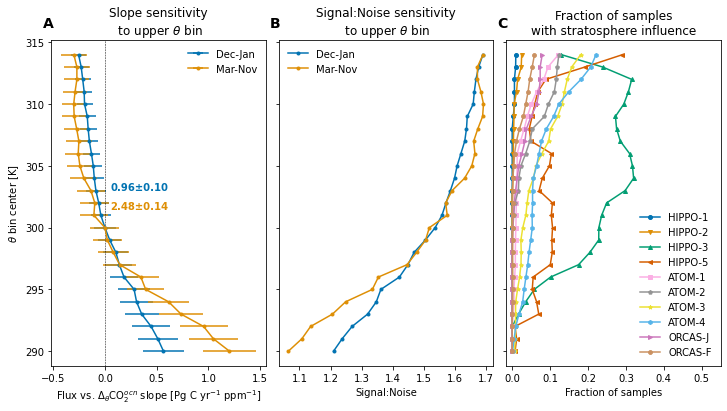

In [12]:
constraint_type = 'ocean_constraint'
df = dfs[constraint_type]

relationship = ('Flux vs. $\Delta_{\\theta}$CO$_2^{ocn}$' 
                if constraint_type == 'ocean_constraint' else
                'Flux vs. $\Delta_{\\theta}$CO$_2$' 
               )
ndx_vline = np.where(ubin_dist == 300.)[0][0]

fig, axs = util.canvas(1, 3, figsize=(4, 6), use_gridspec=True, wspace=0.06)

ax = axs[0, 0]
colors = list(figure_panels.palette_colors)
for n, group in enumerate(['DJF', 'MAMJJASON']):
    label = 'Dec-Jan' if group == 'DJF' else 'Mar-Nov' if group == 'MAMJJASON' else group
    slope = [df.loc[((-90., -45.), (-90., -45.), 90, ubin)].object.df_fits.loc[group].fit_beta[0] 
             for ubin in ubin_dist]
    slope_err = [df.loc[((-90., -45.), (-90., -45.), 90, ubin)].object.df_fits.loc[group].fit_stderr_beta[0] 
                 for ubin in ubin_dist]
    
    ref = slope[ndx_vline]
    ref_err = slope_err[ndx_vline]
    c = colors.pop(0)
    ax.errorbar(slope-ref, ubin_dist, 
                xerr=slope_err, marker='.', label=label,
                color=c,
               )
    ax.text(0.05, 303-n*1.5, f'{ref:0.2f}±{ref_err:0.2f}', c=c, fontweight='bold')

ax.axvline(0., lw=0.5, c='k', linestyle='--')    

    
ax.set_title(f'Slope sensitivity\n to upper $\\theta$ bin')
ax.set_xlabel(f'{relationship} slope [Pg C yr$^{{-1}}$ ppm$^{{-1}}$]')    
ax.set_ylabel('$\\theta$ bin center [K]')
ax.legend(frameon=False);

ax = axs[0, 1]
colors = list(figure_panels.palette_colors)

s2n_ubin_djf = [df.loc[((-90., -45.), (-90., -45.), 90, ubin)].s2n_DJF for ubin in ubin_dist]
s2n_ubin_mamjjason = [df.loc[((-90., -45.), (-90., -45.), 90, ubin)].s2n_MAMJJASON for ubin in ubin_dist]
ax.plot(s2n_ubin_djf, ubin_dist, '.-', label='Dec-Jan', color=colors.pop(0))
ax.plot(s2n_ubin_mamjjason, ubin_dist, '.-', label='Mar-Nov', color=colors.pop(0))

ax.set_title(f'Signal:Noise sensitivity\n to upper $\\theta$ bin')
ax.set_xlabel('Signal:Noise')
ax.set_yticklabels([])
ax.legend(frameon=False);

ax = axs[0, 2]

marker_spec = figure_panels.marker_spec_campaigns()

for c in strat_influence.campaign.values:
    ax.plot(strat_influence.sel(campaign=c), 
            strat_influence.theta,
            label=c, **marker_spec[c], markersize=4)
ax.set_title('Fraction of samples\nwith stratosphere influence')

ax.set_yticks(axs[0, 0].get_yticks())
ax.set_ylim(axs[0, 0].get_ylim())
ax.set_yticklabels([])

xlm = ax.get_xlim()
ax.set_xlim((xlm[0], 0.55))
ax.set_xlabel('Fraction of samples')
ax.legend(frameon=False, loc='lower right', ncol=1);

util.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.01, yoff=0.03)


util.savefig(f'theta-bin-S2N-{constraint_type}')

## Examine dependence on bounding latitude

In [13]:
constraint_type = 'ocean_constraint'
df = dfs[constraint_type]

ubin = 300.
gradient_lat_range = (-90., -45.)

acs = {
    flux_memory: [df.loc[(flux_lat_range, gradient_lat_range, flux_memory, ubin)].object 
                  for flux_lat_range in flux_lat_ranges]
    for flux_memory in flux_memory_dist
}

s2n_air = {}
for flux_memory in [30, 90]:
    assert acs[flux_memory][0].flux_memory == flux_memory
    for group in acs[flux_memory][0].campaign_groups.keys():
        period = 'Mar-Nov' if group == 'MAMJJASON' else 'Dec-Feb' if group == 'DJF' else group        
        key = f'{period} ({flux_memory} d)'        
        s2n_air[key] = [ac.df_fits.loc[group].fit_s2n for ac in acs[flux_memory]]

ec_flux_estimate = {}        
for flux_memory in [30, 90]:
    key = f'Emergent constraint ({flux_memory}d)'            
    ec_flux_estimate[key] = [ac.estimate_ann_mean_flux for ac in acs[flux_memory]]

s2n_srf = {}        
for group in ['DJF', 'JJA']:
    period = 'Dec-Feb' if group == 'DJF' else 'Jun-Aug' if group == 'JJA' else group        
    key = f'{period}'
    s2n_srf[key] = [sc.df_fits.loc[('2009-2020', group)].fit_s2n for sc in scs[constraint_type]]    

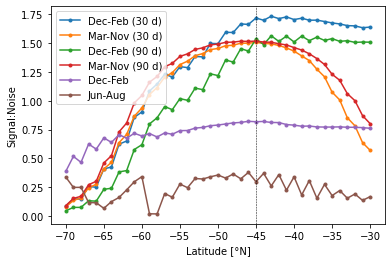

In [14]:
lat = [l[-1] for l in flux_lat_ranges]
for key, values in s2n_air.items():
    plt.plot(lat, values, '.-', label=key,)

for key, values in s2n_srf.items():
    plt.plot(lat, values, '.-', label=key,)
    
#plt.axhline(1., c='k', lw=0.5)
plt.axvline(-45, c='k', lw=0.5, linestyle='--')
plt.legend();
plt.xlabel('Latitude [°N]')
plt.ylabel('Signal:Noise');

### Compute inversion and pCO2-based zonal-mean, seasonal fluxes 

In [15]:
sfco2_ocn_inversions = []
for m, t in model_input_lists['model_tracer_list']:
    if not any(s in m for s in ['TM5', 'CESM', 'prior']) and m not in sfco2_ocn_inversions:
        sfco2_ocn_inversions.append(m)
sfco2_ocn_inversions

['CT2017',
 'CT2019B',
 'CTE2018',
 'CTE2020',
 'MIROC',
 'CAMSv20r1',
 's99oc_v2020',
 's99oc_ADJocI40S_v2020',
 's99oc_SOCCOM_v2020']

In [16]:
sfco2_ocn_soccom = [
    'TM5-Flux-m0f', 'TM5-Flux-mwf', 'TM5-Flux-mmf',
]
sfco2_ocn_pco2_clim = ['SOM-FFN',]

In [17]:
%%capture
dsets_za_djf = {}
dsets_za_jja = {}
for model in sfco2_ocn_inversions+sfco2_ocn_pco2_clim:
    mobj = models.Model(model)
    ds = mobj.open_derived_dataset(
                'fluxes_za_ts_monthly', 
            ).sel(time=slice('1998', '2020'), lat=slice(-80., -30.))
    with xr.set_options(keep_attrs=True):        
        ds = ds.groupby('time.season').mean('time')
    dsets_za_djf[model] =  ds.sel(season='DJF').compute()
    dsets_za_jja[model] = ds.sel(season='JJA').compute()


#### Compute cumulative-sum of fluxes as a function of latitude

In [18]:
%%capture
ds_cum_cache_file = f'{datasets.cache_dir}/sfco2-inversions-cumsum-lat.nc'

if os.path.exists(ds_cum_cache_file) and not clobber:
    ds_cum = xr.open_dataset(ds_cum_cache_file)

else:
    dsets_cum = {}
    for model in sfco2_ocn_inversions:
        mobj = models.Model(model)
        ds_list = []
        for lat_range in flux_lat_ranges:
            ds = mobj.open_derived_dataset(
                    'flux_ts_monthly', lat_range=lat_range
                ).sel(time=slice('1998', '2020'))

            with xr.set_options(keep_attrs=True):                
                dss = ds.groupby('time.season').mean('time').compute()
            ds_list.append(dss)

        dsets_cum[model] = xr.concat(ds_list, 
                                    dim=xr.DataArray(
                                        [rng[-1] for rng in flux_lat_ranges], 
                                        dims=('lat'), 
                                        name='lat')
                                   )
    model = xr.DataArray(sfco2_ocn_inversions, dims=('model'), name='model')
    ds_cum = xr.concat([dsets_cum[m].SFCO2_OCN for m in sfco2_ocn_inversions], dim=model).to_dataset()
    ds_cum.to_netcdf(ds_cum_cache_file)

ds_cum = ds_cum.sel(lat=slice(min_lat, max_lat))
flux_inv_lat = ds_cum.lat
flux_inv_mean = ds_cum.SFCO2_OCN.mean(['model', 'season'])
flux_inv_std = ds_cum.SFCO2_OCN.mean(['season']).std('model')

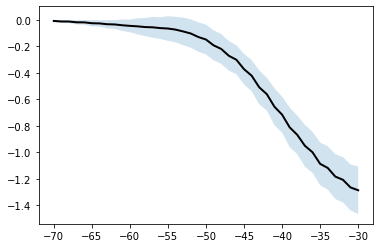

In [19]:
plt.plot(flux_inv_lat, flux_inv_mean, color='k', lw=2)
plt.fill_between(flux_inv_lat, flux_inv_mean - flux_inv_std, 
                 flux_inv_mean + flux_inv_std, alpha=0.2)

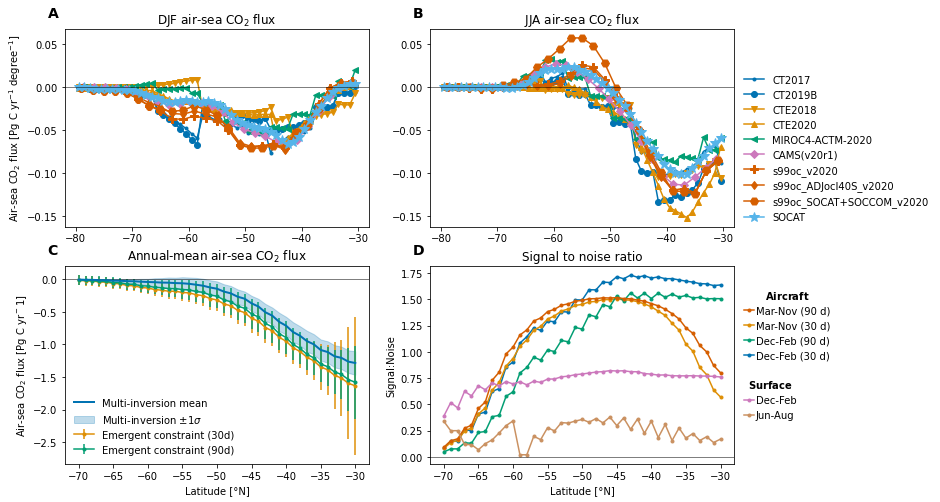

In [20]:
fig, axs = util.canvas(2, 2, wspace=0.25)

marker_spec = figure_panels.marker_spec_models()

#--- DJF flux
ax = axs[0, 0]
for model, ds in dsets_za_djf.items():
    ax.plot(ds.lat, ds.SFCO2_OCN, **marker_spec[model]['CO2_OCN'])
    
ax.set_ylabel(f'Air-sea CO$_2$ flux [{ds.SFCO2_OCN.units}]')    
ax.set_title('DJF air-sea CO$_2$ flux')
ax.axhline(0, lw=0.5, color='k')
ylm_djf = ax.get_ylim()

#--- JJA flux 
ax = axs[0, 1]
for model, ds in dsets_za_jja.items():
    ax.plot(ds.lat, ds.SFCO2_OCN, **marker_spec[model]['CO2_OCN'])
    
ax.set_title('JJA air-sea CO$_2$ flux')
ax.axhline(0, lw=0.5, color='k')
ylm_jja = ax.get_ylim()

h, l = ax.get_legend_handles_labels()
leg1 = ax.legend(h[:], l[:], frameon=False,
                 loc=(1.02, 0.));

# leg2 = ax.legend(h[2:], l[2:], frameon=False,
#                  loc=(0.02, 0.01));

#ax.add_artist(leg1)

ylm = [np.min((ylm_djf[0], ylm_jja[0])), np.max((ylm_djf[1], ylm_jja[1])),]
axs[0, 0].set_ylim(ylm)
axs[0, 1].set_ylim(ylm)

#--- cumulatice flux with latitude
ax = axs[1, 0]

colors = list(figure_panels.palette_colors)
p = ax.plot(
    flux_inv_lat, flux_inv_mean, lw=2, 
    zorder=10, label='Multi-inversion mean', 
    c=colors.pop(0),
)
ax.fill_between(flux_inv_lat, 
                flux_inv_mean - flux_inv_std, 
                flux_inv_mean + flux_inv_std, 
                alpha=0.25, zorder=-10,
                color=p[0].get_color(),
                label='Multi-inversion ±1$\sigma$'
               )

lat = [l[-1] for l in flux_lat_ranges]
for key, values in ec_flux_estimate.items():
    ax.errorbar(lat, [v[0] for v in values], 
                yerr=[v[1] for v in values],
                color=colors.pop(0),
                marker='.', label=key,)

ax.set_ylabel(f'Air-sea CO$_2$ flux [Pg C yr$^{-1}$]')
ax.set_title('Annual-mean air-sea CO$_2$ flux')
ax.axhline(0, lw=0.5, color='k')
ax.set_xlabel('Latitude [°N]')     

ax.legend(frameon=False);

#--- signal to noise ratio
ax = axs[1, 1]
#p = ax.plot(df.lat_ubnd, df.s2n_djf, '.-', label=f'Dec-Feb')# ({flux_memory}d)')
#ax.plot(df.lat_ubnd, df.s2n_mamjjason, '.-', label=f'Mar-Nov')# ({flux_memory}d)')   

colors = list(figure_panels.palette_colors)
lat = [l[-1] for l in flux_lat_ranges]
for key, values in s2n_air.items():
    ax.plot(lat, values, '.-', label=key, c=colors.pop(0))

for key, values in s2n_srf.items():
    ax.plot(lat, values, '.-', label=key, c=colors.pop(0))
    
ax.legend();

ax.axhline(0, lw=0.5, color='k')
ax.set_title('Signal to noise ratio')
ax.set_ylabel(f'Signal:Noise')
ax.set_xlabel('Latitude [°N]')     

ylm = np.array(ax.get_ylim())
ax.set_ylim(ylm)
h, l = ax.get_legend_handles_labels()

order_ndx = [3, 1, 2, 0] #[1, 3, 0, 2,]
lg1 = ax.legend([h[i] for i in order_ndx], [l[i] for i in order_ndx],
          frameon=False,
          loc=(1.02, 0.5), #'upper right',
          handletextpad=0.15,  
          handlelength=1,                
          title='$\\bf{Aircraft}$'                
         )
order_ndx = [-2, -1]
lg2 = ax.legend([h[i] for i in order_ndx], [l[i] for i in order_ndx],
          frameon=False, 
          loc=(1.02, 0.2), #'upper right',
          handletextpad=0.15,
          handlelength=1,
          title='$\\bf{Surface}$'
         )
ax.add_artist(lg1)
    
#axs[0, 0].set_xlim(ax.get_xlim())
#axs[0, 1].set_xlim(ax.get_xlim())

util.label_plots(fig, axs.ravel(), xoff=-0.02)

util.savefig(f'fluxes-region-S2N-{constraint_type}.pdf')